# Simulated Results
The below plot shows the containment index distribution for simulated reads (a function of how contained a read is with positive values meaning truly contained).  The reads are simulated to 30x coverage with the Oxford Nanopore MinION read length distribution (using public Arabidopsis data) from a section of 5 Mbp of the human genome.  

In [1]:
import matplotlib.pyplot as plt

scorefn = '/home/mkirsche/github/ContainedReadRemoval/sim/simulatedscores.txt'

buckets = [1000 * i for i in range(-40, 40)]

containmentIndex = []
names = []
lens = []
starts = []
ends = []
scoreLines = []

numContained, numUncontained = 0, 0
sumContained, sumUncontained = 0, 0

nameToScore = dict()
nameToIndex = dict()

with open(scorefn) as f:
    index = 0
    for line in f:
        tokens = line.split()
        scoreLines.append(tokens)
        curScore = int(tokens[1])
        curEnd = int(tokens[3])
        curStart = int(tokens[2])
        ends.append(curEnd)
        starts.append(curStart)
        curLen = curEnd - curStart
        lens.append(curLen)
        containmentIndex.append(curScore)
        names.append(tokens[0])
        nameToScore[tokens[0]] = curScore
        nameToIndex[tokens[0]] = index
        if curScore >= 0:
            numContained += 1
            sumContained += curLen
        else:
            numUncontained += 1
            sumUncontained += curLen
        index += 1
        
totLength = sumContained + sumUncontained
                  
print('Number of contained reads: ' + str(numContained))
print('Number of uncontained reads: ' + str(numUncontained))
print('Total length of contained reads: ' + str(sumContained))
print('Total length of uncontained reads: ' + str(sumUncontained))
print('Perecent of total length uncontained: ' + str(float(sumUncontained * 100) / float(totLength)))

plt.hist(containmentIndex, bins = buckets, color = 'mediumaquamarine')
plt.title('Containment Index')
plt.show()

Number of contained reads: 17175
Number of uncontained reads: 570
Total length of contained reads: 128006483
Total length of uncontained reads: 22010235
Perecent of total length uncontained: 14.67185477287938


<Figure size 640x480 with 1 Axes>

## How well the filter does
Here is the same plot, but with reads colored based on whether or not my filter removed them.  Note the sharp decline in proportion kept as the y-axis is crossed and it goes from uncontained reads to contained reads. 

I use the following parameters:

k = 15, w = 11 for minimizers

Filter all reads < 12 kbp automatically

Threshold for chain length chosen automatically so approximately 8% of short reads kept as uncontained

Number called uncontained: 1255
Proportion of uncontained reads that were kept: 565 out of 570(recall: 0.9912280701754386)
Proportion of kept reads which are uncontained: 565 out of 1255(precision: 0.450199203187251)
Percent of bases kept: 25.50719513807788
Percent of reads kept: 7.072414764722457
Lowest containment indices of removed reads:
[-660, -561, -415, -359, -18, 14, 32, 179, 241, 318, 351, 377, 423, 437, 479, 508, 527, 567, 571, 615, 648, 696, 765, 831, 847, 855, 905, 953, 1023, 1096]


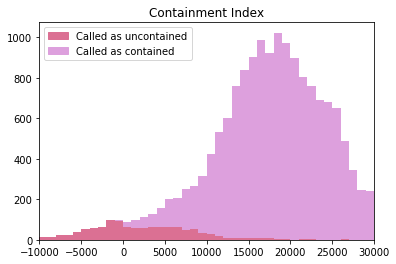

In [2]:
import matplotlib.patches as mpatches

uncontainedCI = []
containedCI = []

myUncontainedLen = 0

resultsfn = '/home/mkirsche/eclipse-workspace/PacBioHashing/uncontainedreadnames.txt'

uncontainedNames = set()

with open(resultsfn) as f:
    for line in f:
        uncontainedNames.add(line.split()[0])
        
print('Number called uncontained: ' + str(len(uncontainedNames)))

tp = 0

for a in nameToScore:
    b = nameToScore[a]
    if a in uncontainedNames:
        uncontainedCI.append(b)
        myUncontainedLen += lens[nameToIndex[a]]
        if b < 0:
            tp += 1
    else:
        containedCI.append(b)
        
recall = float(tp) / float(numUncontained)
precision = float(tp) / float(len(uncontainedNames))
        
print('Proportion of uncontained reads that were kept: ' + str(tp) + ' out of ' + str(numUncontained) + '(recall: ' + str(recall) + ')')
print('Proportion of kept reads which are uncontained: ' + str(tp) + ' out of ' + str(len(uncontainedNames)) + '(precision: ' + str(precision) + ')')


print('Percent of bases kept: '+ str(float(myUncontainedLen * 100) / float(totLength)))
print('Percent of reads kept: '+ str(float(len(uncontainedCI) * 100) / float(numContained + numUncontained)))

colors = ['palevioletred', 'plum']

containedCI.sort()
print('Lowest containment indices of removed reads:')
print(containedCI[0:30])

uncontainedCI.sort()
        
plt.hist([uncontainedCI, containedCI], color = colors , bins = buckets, stacked = True)

labels = ['Called as uncontained', 'Called as contained']
legendHandles = []
for i in range(0, len(colors)):
    legendHandles.append(mpatches.Patch(color=colors[i], label=labels[i]))
plt.legend(handles=legendHandles)
plt.title('Containment Index')
plt.xlim(-10000, 30000)

plt.show()

## Number of false positives and negatives:

In [3]:
wronglyRemovedNames = set()
wronglyKeptNames = set()

for name in nameToScore:
    score = nameToScore[name]
    if score < 0 and name not in uncontainedNames:
        wronglyRemovedNames.add(name)
    if score >= 0 and name in uncontainedNames:
        wronglyKeptNames.add(name)
        
print('Wrongly removed count: ' + str(len(wronglyRemovedNames)))
print('Wrongly kept count: ' + str(len(wronglyKeptNames)))

Wrongly removed count: 5
Wrongly kept count: 690


## Looking at the chains of minimizer matches within the more extreme wrong guesses

In [4]:
nameToLog = dict()
logfile = '/home/mkirsche/eclipse-workspace/PacBioHashing/log.txt'
with open(logfile) as f:
    for line in f:
        tokens = line.split('\t')
        curName = tokens[0].split()[0]
        nameToLog[curName] = tokens

In [5]:
print('Wrongly discarded read which are most uncontained')
for name in wronglyRemovedNames:
    if name in nameToLog and nameToScore[name] < 0 and nameToScore[name] <= containedCI[10]:
        tokens = nameToLog[name]
        longestChain = int(tokens[1])
        numMinimizers = int(tokens[5])
        readLength = int(tokens[3])
        chain = tokens[2]
        score = tokens[11]
        ci = nameToScore[name]
        print(name + ' ' + str(longestChain) + ' ' + str(numMinimizers) + ' ' + str(readLength) + ' ' + str(ci) + ' ' + chain)
        print(score)
        print('')
    else:
        print(name + ' ' + str(lens[nameToIndex[name]]) + ' ' + str(nameToScore[name]))
        print(str(starts[nameToIndex[name]]) + ' ' + str(ends[nameToIndex[name]]))
        print('')

Wrongly discarded read which are most uncontained
read13885 90 5346 29346 -561 [30, 865, 1226, 1227, 2324, 2427, 2603, 2983, 2986, 3363, 3399, 3407, 3410, 4126, 4348, 4626, 4836, 5110, 5119, 5337, 5382, 5383, 5524, 5629, 5928, 5971, 6045, 6169, 6211, 6367, 6377, 6752, 7126, 7390, 7397, 7816, 7819, 8189, 8308, 8442, 8443, 8699, 9227, 9439, 10250, 11527, 12478, 12479, 12646, 13340, 13897, 13984, 14146, 14464, 15946, 16328, 17585, 19954, 20275, 20359, 20450, 20741, 20743, 20746, 20785, 21033, 21183, 21297, 21720, 21722, 21725, 22653, 22661, 23156, 23217, 23220, 23640, 24533, 25623, 25883, 25891, 26101, 26750, 26778, 26942, 26951, 28154, 28752, 28753, 28754]
0.0


read16185 111 6699 36848 -18 [423, 572, 674, 1286, 1381, 1382, 1520, 1589, 1854, 2243, 2244, 2879, 2888, 3051, 3782, 3927, 3930, 3935, 3943, 4355, 4438, 4913, 4915, 5432, 6303, 6548, 6623, 7014, 7299, 7330, 7939, 7942, 7981, 8497, 9235, 9580, 9868, 10281, 10413, 10477, 11267, 11640, 11699, 12595, 12801, 12873, 12874, 13096, 13166

In [6]:
print('Wrongly kept reads which are most contained')
for name in wronglyKeptNames:
    if name in nameToLog and nameToScore[name] > 0 and nameToScore[name] >= uncontainedCI[len(uncontainedCI)-5]:
        tokens = nameToLog[name]
        longestChain = int(tokens[1])
        numMinimizers = int(tokens[5])
        readLength = int(tokens[3])
        chain = tokens[2]
        score = tokens[11]
        ci = nameToScore[name]
        print(name + ' ' + str(longestChain) + ' ' + str(numMinimizers) + ' ' + str(readLength) + ' ' + str(ci) + ' ' + chain)
        print(score)
        print('')

Wrongly kept reads which are most contained
read2222 67 4828 26866 26996 [7464, 7941, 8176, 8444, 8559, 8732, 8816, 8824, 9099, 9359, 11278, 12089, 12597, 12861, 13297, 13298, 13323, 13481, 13556, 13557, 13560, 13888, 13998, 14005, 14499, 14893, 16021, 16022, 16415, 16593, 16747, 17213, 17428, 17430, 17434, 17731, 18077, 18404, 18903, 18906, 19011, 19014, 20089, 20950, 20951, 20993, 21717, 21724, 21800, 21965, 22928, 22929, 23202, 23205, 23637, 23787, 23826, 25071, 25232, 25234, 25789, 25799, 25801, 25805, 25880, 26186, 26501]
-1.0


read8980 73 5621 31116 26855 [1303, 1645, 1646, 1770, 1779, 2275, 3105, 3693, 4098, 4446, 6040, 6061, 6378, 7232, 7235, 7275, 7586, 7691, 7945, 7951, 8769, 9252, 9637, 9668, 9784, 10333, 11120, 11129, 11535, 11623, 11757, 11841, 11847, 12393, 13185, 13541, 13598, 13962, 14669, 16527, 16576, 18089, 19153, 19280, 20081, 20516, 21930, 21931, 21935, 22673, 22864, 23600, 24076, 24887, 24894, 25149, 26011, 26570, 26578, 26579, 27194, 27195, 27968, 28164, 28168, 

## How the number of incorrectly removed reads compares to a length-based threshold
Here the length threshold is set to match the number of removed reads of the filter settings.  Note that even with the same number of reads, the length-based filter keeps 5% more of the overall bases because it throws out mostly shorter reads.  Even so, my filter is outperforming the length-based filter in terms of the number of incorrectly removed reads.

In [7]:
def countLen(countKeep, lens, ct):
    sorter = []
    for i in range(0, len(lens)):
        sorter.append((lens[i], ct[i]))
    sorter.sort()
    bad = 0
    totRemovedLen = 0
    lt = str(sorter[len(lens)-countKeep][0])
    print('Length threshold to remove same number of reads: ' + str(lt))
    for i in range(0, len(lens)-countKeep-1):
        totRemovedLen += sorter[i][0]
        if sorter[i][1] < 0:
            bad += 1
    print('Length-based incorrectly removed: ' + str(bad))
    percentBasesRemoved = 100*float(totLength - totRemovedLen) / float(totLength)
    print('Length-based percent of bases kept ' + str(percentBasesRemoved))
   
print('My incorrectly removed: ' + str(len(wronglyRemovedNames)))
countLen(len(uncontainedNames), lens, containmentIndex)

print('My percent of bases kept: '+ str(float(myUncontainedLen * 100) / float(totLength)))

My incorrectly removed: 5
Length threshold to remove same number of reads: 26406
Length-based incorrectly removed: 71
Length-based percent of bases kept 29.706071825941425
My percent of bases kept: 25.50719513807788


## Quality of features used
Investigating how well things like length of kmer chain correlate with actual containment

Sample line: ['read13486', '49', '[336, 694, 1492, 1620, 1726, 2404, 2883, 3031, 3287, 3811, 3812, 3821, 3980, 4489, 4709, 4844, 5217, 5226, 5229, 5234, 5543, 5883, 6041, 6047, 6052, 6056, 6065, 6505, 6748, 6852, 6955, 6962, 7011, 7204, 7205, 7832, 7954, 8172, 8367, 8452, 10147, 11111, 11144, 11145, 11146, 11149, 11202, 11607, 11822]', '12082', '164', '2192', 'true', '336', '245', 'read5288', '[1183, 1541, 2339, 2467, 2573, 3251, 3730, 3878, 4134, 4658, 4659, 4668, 4827, 5354, 5556, 5691, 6064, 6073, 6076, 6081, 6390, 6730, 6888, 6894, 6899, 6903, 6912, 7352, 7595, 7699, 7802, 7809, 7858, 8051, 8052, 8679, 8801, 9019, 9214, 9299, 10994, 11958, 11991, 11992, 11993, 11996, 12049, 12454, 12669]', '0.0\n']


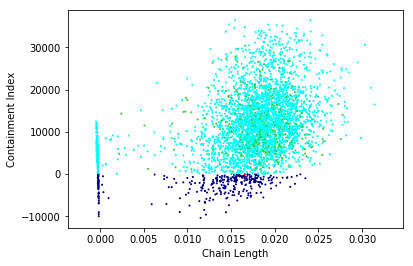

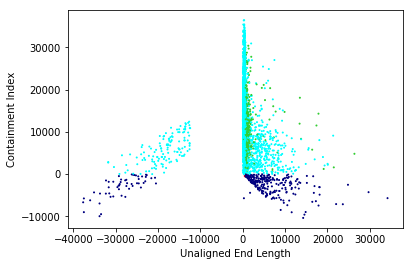

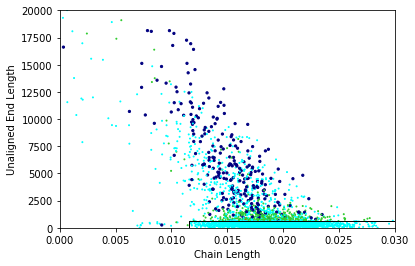

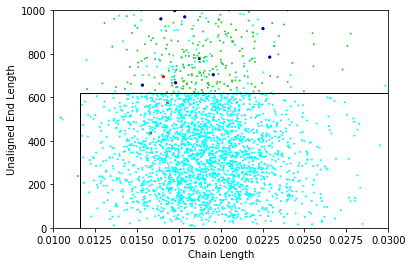

In [8]:
print('Sample line: ' + str(next(iter(nameToLog.values()))))

chainProportionList = []
endLengthList = []
scoreList = []
indexList = []
colors = []
sizes = []
for x in nameToLog:
    tokens = nameToLog[x]
    longestChain = float(tokens[1])
    numMinimizers = float(tokens[5])
    end = max(float(tokens[7]), float(tokens[8]))
    dpScore = float(tokens[11])
    curIndex = nameToIndex[x]
    indexList.append(curIndex)
    score = nameToScore[x]
    if score < 0:
        if x in wronglyRemovedNames:
            colors.append('red')
        else:
            colors.append('navy')
        sizes.append(5)
    else:
        if dpScore > .5:
            colors.append('limegreen')
        else:
            colors.append('cyan')
        sizes.append(1)
    chainProportionList.append(longestChain / numMinimizers)
    scoreList.append(score)
    endLengthList.append(end)
plt.scatter(chainProportionList, scoreList, c = colors, s = 1)
plt.xlabel('Chain Length')
plt.ylabel('Containment Index')
plt.show()


plt.xlabel('Unaligned End Length')
plt.ylabel('Containment Index')
plt.scatter(endLengthList, scoreList, c = colors, s = 1)
plt.show()

plt.xlabel('Chain Length')
plt.ylabel('Unaligned End Length')
plt.scatter(chainProportionList, endLengthList, c = colors, s = sizes)
plt.xlim(0, 0.03)
plt.ylim(0, 20000)
plt.plot([0.0115745, 1], [622, 622], color='black', linestyle='-', linewidth=1)
plt.plot([0.0115745, 0.0115745], [0, 622], color='black', linestyle='-', linewidth=1)
plt.show()


plt.xlabel('Chain Length')
plt.ylabel('Unaligned End Length')
plt.scatter(chainProportionList, endLengthList, c = colors, s = sizes)
plt.xlim(0.01, 0.03)
plt.ylim(0, 1000)
plt.plot([0.0115745, 1], [622, 622], color='black', linestyle='-', linewidth=1)
plt.plot([0.0115745, 0.0115745], [0, 622], color='black', linestyle='-', linewidth=1)
plt.show()

In [9]:
for i in range(len(scoreList)):
    if scoreList[i] < 0 and names[indexList[i]] in wronglyRemovedNames:
        print('Containment index: ' + str(scoreList[i]))
        print('End length: ' + str(endLengthList[i]))
        tokens = nameToLog[names[indexList[i]]]
        #print(tokens)
        containingReadName = tokens[9].strip()
        print('Supposedly contained by: ' + containingReadName)
        print('My interval: ' + str(starts[indexList[i]])+' '+str(ends[indexList[i]]))
        if containingReadName == 'none':
            continue
        containingIndex = nameToIndex[containingReadName]
        print('Containing read interval: ' + str(starts[containingIndex])+' '+str(ends[containingIndex]))
        print(scoreLines[indexList[i]])
        print()

Containment index: -18
End length: 695.0
Supposedly contained by: read12641
My interval: 64338 101186
Containing read interval: 53271 101168
['read16185', '-18', '64338', '101186', 'read12641']

Containment index: -561
End length: 577.0
Supposedly contained by: read14409
My interval: 289329 318675
Containing read interval: 264588 318114
['read13885', '-561', '289329', '318675', 'read14409']

Containment index: -415
End length: 437.0
Supposedly contained by: read16799
My interval: 743155 775073
Containing read interval: 733487 774658
['read6937', '-415', '743155', '775073', 'read16799']



Number of kept contained reads which have found a correct containing read: 11
Number of kept contained reads which have not found a correct containing read: 589
Number of indexed reads which are contained: 90


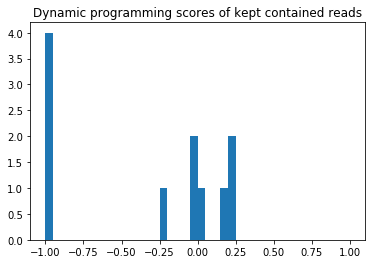

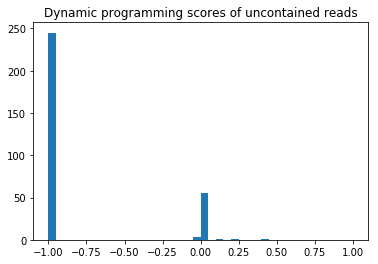

In [10]:
countYes = 0
countNo = 0

accountedFor = set()

containedDpScores = []
uncontainedDpScores = []

for i in range(0, len(scoreList)):
    curName = names[indexList[i]]
    tokens = nameToLog[curName]
    curDp = float(tokens[11].strip())
    
    if nameToScore[curName] < 0:
        uncontainedDpScores.append(float(tokens[11].strip()))
    elif names[indexList[i]] in wronglyKeptNames:
        tokens = nameToLog[names[indexList[i]]]
        containingReadName = tokens[9].strip()
        if containingReadName == 'none':
            countNo += 1
            continue
        containingIndex = nameToIndex[containingReadName]
        myA, myB = starts[indexList[i]], ends[indexList[i]]
        theirA, theirB = starts[containingIndex], ends[containingIndex]
        
        if myA >= theirA and myB <= theirB:
            containedDpScores.append(curDp)
            countYes += 1
        else:
            countNo += 1
        accountedFor.add(names[indexList[i]])
print('Number of kept contained reads which have found a correct containing read: ' + str(countYes))
print('Number of kept contained reads which have not found a correct containing read: '+str(countNo))
numIndexedWrong = 0
for i in range(0, len(lens)):
    if lens[i] >= 37726 and names[i] in wronglyKeptNames:
        numIndexedWrong += 1
        accountedFor.add(names[i])
print('Number of indexed reads which are contained: ' + str(numIndexedWrong))

for name in wronglyKeptNames:
    if name not in accountedFor:
        idx = nameToIndex[name]
        #print(name + ' ' + str(lens[idx]) + ' ' + str(scoreLines[idx]))

buckets = [-1 + 0.05 * i for i in range(0, 41)]
        
containedDpScores.sort()
#print(containedDpScores)
plt.title('Dynamic programming scores of kept contained reads')
plt.hist(containedDpScores, bins=buckets)
plt.show()

uncontainedDpScores.sort()
#print(uncontainedDpScores)
plt.title('Dynamic programming scores of uncontained reads')
plt.hist(uncontainedDpScores, bins=buckets)
plt.show()